In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
import nibabel as nib
import numpy as np
from tqdm import tqdm
from torchvision.transforms import Compose

In [16]:
# Custom dataset class for handling NIfTI files
class BrainDataset(Dataset):
    def __init__(self, t1w_files, t2w_files, fa_files, adc_files, transform=None):
        self.t1w_files = t1w_files
        self.t2w_files = t2w_files
        # self.fa_files = fa_files
        self.adc_files = adc_files
        self.transform = transform

    def __len__(self):
        return len(self.t1w_files)

    def __getitem__(self, idx):
        t1w_image = nib.load(self.t1w_files[idx]).get_fdata()
        t2w_image = nib.load(self.t2w_files[idx]).get_fdata()
        # fa_image = nib.load(self.fa_files[idx]).get_fdata()
        adc_image = nib.load(self.adc_files[idx]).get_fdata()

        # input_image = np.stack([t1w_image, t2w_image], axis=0)
        t1w_image = np.stack([t1w_image], axis=0)
        # target_image = np.stack([fa_image, adc_image], axis=0)
        t2w_image = np.stack([t2w_image], axis=0)
        adc_image = np.stack([adc_image], axis=0)

        # if self.transform:
            # input_image = self.transform(input_image)
            # target_image = self.transform(target_image)

        # return input_image, target_image
        return t1w_image, t2w_image, adc_image

In [7]:
cd project2

c:\Users\keert\project2


In [28]:
cd ../..

c:\Users\keert\project2


In [29]:
# os.chdir('./data/input')
os.chdir('./data/output')

patient_folders = [folder for folder in os.listdir() if os.path.isdir(folder) and folder.startswith('0')]

t1w_files = []
t2w_files = []
fa_files = []
adc_files = []

for patient_folder in patient_folders:
    registered_path = os.path.join(patient_folder, "registered")
    registered2_path = os.path.join(patient_folder, "registered2")
    normalized_path = os.path.join(patient_folder, 'normalized')

    t1w_files.append(os.path.join(normalized_path, "T1w_1mm_normalized.nii.gz"))
    t2w_files.append(os.path.join(registered_path, "T2w_registered.nii.gz"))
    adc_files.append(os.path.join(registered2_path, "ADC_registered2.nii.gz"))
    fa_files.append(os.path.join(registered2_path, "FA_registered2.nii.gz"))

    # path = os.path.join(patient_folder, patient_folder)

    # t1w_files.append(os.path.join(path, "T1w_1mm.nii.gz"))
    # t2w_files.append(os.path.join(path, "T2w_1mm_noalign.nii.gz"))
    # adc_files.append(os.path.join(path, "ADC_deformed.nii.gz"))
    # fa_files.append(os.path.join(path, "FA_deformed.nii.gz"))

dataset = BrainDataset(t1w_files, t2w_files, fa_files, adc_files, transform=Compose([torch.tensor]))
# dataset = BrainDataset(t1w_files, t2w_files, t1w_files, t2w_files, transform=Compose([torch.tensor]))
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 0 for FA, 1 for ADC
output_modality = 1

print(t1w_files)

['001\\001\\T1w_1mm.nii.gz', '002\\002\\T1w_1mm.nii.gz', '003\\003\\T1w_1mm.nii.gz', '004\\004\\T1w_1mm.nii.gz']


In [20]:
input_shape = (1, 182, 218, 182)

nc = 1 # num channels

ngf = 32 # size of feature maps in generator

ndf = 32 # size of feature maps in discriminator

num_epochs = 1 # 200

lr = 0.0002

betas = (0.5, 0.999) # beta1 hyperparameter for Adam optimizers

ngpu = 1 # number of GPUs available, 0 for CPU mode

batch_size = 128 # batch size during training

latent_dim = 100

ngpu = 1 # Number of GPUs available. Use 0 for CPU mode.

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [21]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.convnet = nn.Sequential(
            # input is 1 x 182 x 218 x 182
            nn.Conv3d(1, 32, kernel_size=(3, 3, 3), padding=1),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            # input is 32 x 91 x 109 x 91
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            # input is 64 x 45 x 54 x 45
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=1),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            nn.Flatten(),
            # input is 128 x 22 x 27 x 22
            nn.Linear(1672704, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.LeakyReLU()
            # nn.Linear(128, 64),
            # nn.Linear(64, 1),
            # nn.ReLU(),
            # nn.Sigmoid(), # is this needed?
        )

    def forward(self, x):
        return self.convnet(x)

In [22]:
t1_model = ConvNet()
t2_model = ConvNet()

In [23]:
# Define the input shape
img_shape = (2, 182, 218, 182)

# Define the generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc_layer = nn.Sequential(
            nn.Linear(latent_dim * 2, 128 * 22 * 27 * 22),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128 * 22 * 27 * 22)
        )
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1)),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose3d(64, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1)),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose3d(32, 1, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1)),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc_layer(x)
        x = x.view(x.shape[0], 128, 22, 27, 22) # reshaping tensor
        x = self.conv_layers(x)
        return x

In [24]:
# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.LeakyReLU(0.2),
            nn.Dropout3d(0.25),
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.LeakyReLU(0.2),
            #nn.Dropout3d(0.25),
            nn.Flatten(),
            # nn.Linear(64 * 23* 28 * 23, 128),
            # nn.LeakyReLU(0.2), #inplace=True
            # nn.Linear(128, 64),
            # nn.LeakyReLU(0.2), #inplace=True
            # nn.Linear(64, 1),
            # nn.Linear(64 * 36 * 43 * 36, 1),
            nn.Linear(7448320, 1), # 64 x 45 x 54 x 45
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x)

In [25]:
# Create the discriminator and generator models
discriminator = Discriminator()
generator = Generator()

# generator.apply(weights_init)
# discriminator.apply(weights_init)

# Define the loss function and optimizer for the discriminator and generator
adversarial_loss = nn.BCELoss()
al_w = 1
generative_loss = nn.MSELoss()
gl_w = 0.1
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
optimizer_T1 = torch.optim.Adam(t1_model.parameters(), lr=lr*10, betas=betas)
optimizer_T2 = torch.optim.Adam(t2_model.parameters(), lr=lr*10, betas=betas)

In [30]:
## Change to True / False if you do / do not want 
## to load the previously saved state dictionaries
load = False
if load:
    generator.load_state_dict(torch.load("generator.pt"))
    discriminator.load_state_dict(torch.load("discriminator.pt"))
    t1_model.load_state_dict(torch.load("t1_model.pt"))
    t2_model.load_state_dict(torch.load("t2_model.pt"))

img_list = []
G_losses = []
D_losses = []
iters = 0

batch_size = 2
img_shape = (batch_size, 182, 218, 182)

# Train the models
for epoch in range(num_epochs):
    # # Train the discriminator
    # optimizer_D.zero_grad()
    i = 0
    for t1, t2, fa in tqdm(dataloader):
        t1, t2, fa = t1.to(device), t2.to(device), fa.to(device)
        
        # update D: maximize log(D(x)) + log(1 - D(G(z)))
        # train with all-real batch
        discriminator.zero_grad()
        real_images = fa.float()
        real_labels = torch.ones(real_images.shape[0], 1).cuda()
        real_predictions = discriminator(real_images)
        real_loss = adversarial_loss(real_predictions, real_labels)
        real_loss.backward()

        # create latent space and update D with fake image
        t1_latent = t1_model(t1.float()) 
        t2_latent = t2_model(t2.float())
        # latent = t1_latent + t2_latent
        latent = torch.concat((t1_latent, t2_latent), 1)
        fake_images = generator(latent)
        fake_images = torch.nn.functional.pad(fake_images, pad=(3, 3, 1, 1, 3, 3), mode='replicate') # kinda sketch 
        fake_labels = torch.zeros(fake_images.shape[0], 1).cuda()
        fake_predictions = discriminator(fake_images.detach())
        fake_loss = adversarial_loss(fake_predictions, fake_labels)
        fake_loss.backward()

        discriminator_loss = real_loss + fake_loss
        optimizer_D.step()

        # update G network: maximize log(D(G(z)))
        generator.zero_grad()
        t1_model.zero_grad()
        t2_model.zero_grad()

        fake_images = generator(latent)
        fake_images = torch.nn.functional.pad(fake_images, pad=(3, 3, 1, 1, 3, 3), mode='replicate') # kinda sketch 
        fake_predictions = discriminator(fake_images)
        errG = adversarial_loss(fake_predictions, real_labels)
        errR = generative_loss(fake_images, fa.float())
        generator_loss = al_w*errG + gl_w*errR
        generator_loss.backward()
        optimizer_G.step()     
        optimizer_T1.step()
        optimizer_T2.step()   

        # output training stats
        #if i % 50 == 0:
        G_losses.append(generator_loss.item())
        D_losses.append(discriminator_loss.item())

        # Print the losses
        if i % 100 == 0:
            print("Epoch [%d/%d], Step [%d/%d], Discriminator Loss: %.4f, Generator Loss: %.4f"
                  % (epoch, num_epochs, i, len(dataloader), discriminator_loss.item(), generator_loss.item()))
            torch.save(generator.state_dict(), "generator.pt")
            torch.save(discriminator.state_dict(), "discriminator.pt")
            torch.save(t1_model.state_dict(), "t1_model.pt")
            torch.save(t2_model.state_dict(), "t2_model.pt")
        i += 1
            
        iters += 1

        # t1_latent = t1_model(t1) 

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [0/1], Step [0/2], Discriminator Loss: 2.0071, Generator Loss: 4588.7427


 50%|█████     | 1/2 [01:48<01:48, 108.19s/it]


KeyboardInterrupt: 

NameError: name 'G_losses' is not defined

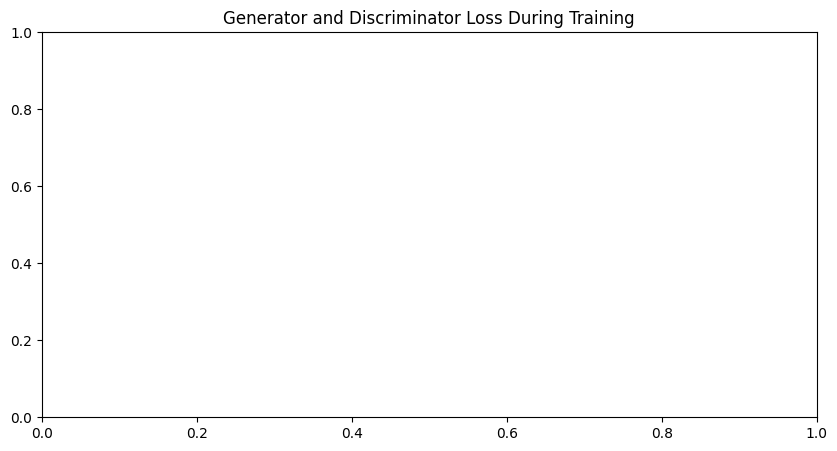

In [1]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [2]:
load = False
if load:
    generator.load_state_dict(torch.load("generator_fa.pt"))
    discriminator.load_state_dict(torch.load("discriminator_fa.pt"))
    t1_model.load_state_dict(torch.load("t1_model_fa.pt"))
    t2_model.load_state_dict(torch.load("t2_model_fa.pt"))

def generate_img(t1w_image, t2w_image):
    t1w_image = np.stack([t1w_image], axis=0)
    t2w_image = np.stack([t2w_image], axis=0)
    t1_latent = t1_model(t1w_image.float()) 
    t2_latent = t2_model(t2w_image.float())
    latent = torch.concat((t1_latent, t2_latent), 1)
    generated_image = generator(latent)
    generated_image = torch.nn.functional.pad(generated_image, pad=(3, 3, 1, 1, 3, 3), mode='replicate') # kinda sketch 
    return generated_image

In [ ]:
import SimpleITK as sitk

# Change the working directory to the "data" folder
os.chdir('../data/output')

# Get the list of patient folders
patient_folders = [folder for folder in os.listdir() if os.path.isdir(folder)]

# Register images to T1w space using Diffeomorphic Demons
for patient_folder in patient_folders:
    output_folder = os.path.abspath(patient_folder)

    # Create the output folder for the registered images
    synthesized_output_folder = os.path.join(output_folder, "synthesized")
    os.makedirs(synthesized_output_folder, exist_ok=True)

    t1w_image_path = os.path.join(output_folder, "normalized", "T1w_1mm_normalized.nii.gz")
    t2w_image_path = os.path.join(output_folder, "registered", "T2w_registered.nii.gz")
    fa_image_path = os.path.join(output_folder, "registered2", "FA_registered.nii.gz")
    adc_image_path = os.path.join(output_folder, "registered2", "ADC_registered.nii.gz")

    # synthesized_image_path = os.path.join(synthesized_output_folder, "ADC_synthesized.nii.gz")
    synthesized_image_path = os.path.join(synthesized_output_folder, "FA_synthesized.nii.gz")

    t1w_image_file = nib.load(t1w_image_path)
    t1w_image = t1w_image_file.get_fdata()
    t2w_image_file = nib.load(t2w_image_path)
    t2w_image = t2w_image_file.get_fdata()
    fa_image_file = nib.load(fa_image_path)
    fa_image = fa_image_file.get_fdata()
    adc_image_file = nib.load(adc_image_path)
    adc_image = adc_image_file.get_fdata()

    generated_image = generate_img(t1w_image, t2w_image)

    # visualize output vs actual file
    plt.rcParams["figure.figsize"]=20,20
    plt.figure()
    plt.subplot(1,4,1)
    plt.imshow(generated_image[:,:,100])
    plt.title('Generated Image')
    plt.subplot(1,4,2)
    plt.imshow(adc_image[:,:,100])
    plt.title('Actual Image')
    plt.subplot(1,4,3)
    plt.imshow(generated_image[105,:,:])
    plt.title('Generated Image')
    plt.subplot(1,4,4)
    plt.imshow(adc_image[105,:,:])
    plt.title('Actual Image')
    plt.show()

    sitk.WriteImage(generated_image, synthesized_image_path)